In [1]:
%load_ext autoreload
%autoreload 2

### Import required libraries

In [2]:
import numpy as np
import pandas as pd

import csv as csv
import sklearn
import math
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score,KFold,train_test_split,GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import xgboost
import lightgbm as lgb

from utils import save_to_csv, reduce_memory_usage,custom_kfold_scorer 

### Open the CSV files containing train and test data

In [3]:
train_df = pd.read_csv("./train_2.csv")
test_df = pd.read_csv("./test_2.csv")

### Reduce the size of dataframe to save memory during training

In [4]:
train_df, _ = reduce_memory_usage(train_df)
test_df, _ = reduce_memory_usage(test_df)

Memory usage of properties dataframe is : 55.995635986328125  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  38.702903747558594  MB
This is  69.117714382257 % of the initial size
Memory usage of properties dataframe is : 13.1756591796875  MB
__MEMORY USAGE AFTER COMPLETION:__
Memory usage is:  9.264171600341797  MB
This is  70.31277504979849 % of the initial size


### Training data

In [5]:
train_df.head()

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,latitude,longitude,subzone,planning_area,region,resale_price,month_no,year,storey,lat_long
0,pasir ris,4-room,440,pasir ris drive 4,118.0,model a,1989,1.369008,103.958694,pasir ris drive,pasir ris,east region,209700.0,8,2001,2,"(1.3690080642700195, 103.95869445800781)"
1,punggol,5-room,196B,punggol field,110.0,improved,2003,1.399007,103.906990,punggol field,punggol,north-east region,402300.0,10,2014,11,"(1.3990070819854736, 103.90699005126953)"
2,sengkang,5-room,404A,fernvale lane,112.0,premium apartment,2004,1.388348,103.873817,fernvale,sengkang,north-east region,351000.0,9,2020,2,"(1.3883482217788696, 103.87381744384766)"
3,clementi,3-room,375,clementi avenue 4,67.0,new generation,1980,1.318493,103.766701,clementi north,clementi,west region,151200.0,10,2000,8,"(1.3184930086135864, 103.7667007446289)"
4,bukit batok,3-room,163,bukit batok street 11,73.0,model a,1985,1.348150,103.742661,bukit batok west,bukit batok,west region,318600.0,1,2013,8,"(1.3481495380401611, 103.74266052246094)"


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431732 entries, 0 to 431731
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   town                 431732 non-null  object 
 1   flat_type            431732 non-null  object 
 2   block                431732 non-null  object 
 3   street_name          431732 non-null  object 
 4   floor_area_sqm       431732 non-null  float32
 5   flat_model           431732 non-null  object 
 6   lease_commence_date  431732 non-null  uint16 
 7   latitude             431732 non-null  float32
 8   longitude            431732 non-null  float32
 9   subzone              431732 non-null  object 
 10  planning_area        431732 non-null  object 
 11  region               431732 non-null  object 
 12  resale_price         431732 non-null  float32
 13  month_no             431732 non-null  uint8  
 14  year                 431732 non-null  uint16 
 15  storey           

### Segregate the columns

In [7]:
integer_columns = [
    "lease_commence_date",
    "storey",
    "month_no",
    "year",
]

float_columns = [
    "floor_area_sqm",
]

target_column = [
    "resale_price"
]

## Categorical columns need to be encoded before training
categorical_columns = [
    "town",
    "flat_type",
    "flat_model",
    "subzone",
    "planning_area",
    "region"
]

## We will drop these columns before training
drop_columns = [
    "lat_long",
    "block",
    "street_name",
    "latitude",
    "longitude"
]

### Drop the selected columns

In [8]:
train_df = train_df.drop(columns=drop_columns)
test_df = test_df.drop(columns=drop_columns)

## Correlation between features

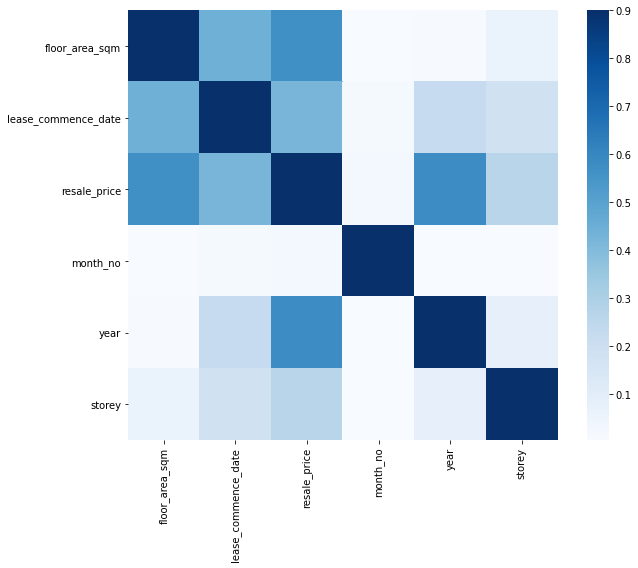

In [14]:
corr = train_df.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corr, vmax=0.9, cmap="Blues", square=True)
plt.tight_layout()
#plt.savefig("./correlation.tiff",dpi=300)

In [12]:
corr[['resale_price']].sort_values(by='resale_price',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,resale_price
resale_price,1.000000
year,0.578717
floor_area_sqm,0.570385
lease_commence_date,0.423578
storey,0.269431
month_no,0.025448


### One hot encode categorical columns

In [15]:
for col in categorical_columns:
    train_df = pd.concat([train_df, pd.get_dummies(train_df[col], prefix=col)],axis=1)
train_df = train_df.drop(columns=categorical_columns)

for col in categorical_columns:
    test_df = pd.concat([test_df, pd.get_dummies(test_df[col], prefix=col)],axis=1)
test_df = test_df.drop(columns=categorical_columns)

### Check if the columns in both test data and train data are same after one-hot encoding

In [16]:
columns_in_test_not_in_train = test_df.columns.difference(train_df.columns).tolist()
#print(columns_in_test_not_in_train)
columns_in_train_not_in_test = train_df.columns.difference((test_df.columns)).tolist()
columns_in_train_not_in_test.remove('resale_price')
#print(columns_in_train_not_in_test)
if not columns_in_test_not_in_train and not columns_in_train_not_in_test:
    print("Columns are same")

Columns are same


### Split training data into training and validation sets

In [17]:
train_data = train_df.sample(frac=1)
train_labels = train_data.pop('resale_price')
train_x, val_x, train_y, val_y = train_test_split(train_data,train_labels,train_size=0.8)

## Linear Regression

In [18]:
reg = LinearRegression(normalize=True,copy_X=True,n_jobs=-1)

In [19]:
%%time
reg.fit(train_x, train_y)

Wall time: 3.29 s


LinearRegression(n_jobs=-1, normalize=True)

In [20]:
train_prediction = reg.predict(train_x)
val_prediction = reg.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 53049.11
Validation error(RMSE) : 53017.98
R2 score for training data : 0.8332990861771566
R2 score for validation data : 0.8326219193008754


-----------------------

## Decision Tree

#### Train using default hyperparameters

In [21]:
dt_1 = tree.DecisionTreeRegressor()

In [22]:
%%time
dt_1 = dt_1.fit(train_x, train_y)

Wall time: 9.31 s


In [23]:
train_prediction = dt_1.predict(train_x)
val_prediction = dt_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 4146.6082100001795
Validation error(RMSE) : 25841.098590722613
R2 score for training data : 0.998981484128565
R2 score for validation data : 0.9602374542136288


#### Modify max_depth and min_samples_split and try next model

In [27]:
dt_3 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=15)
dt_3 = dt_3.fit(train_x, train_y)

In [28]:
train_prediction = dt_3.predict(train_x)
val_prediction = dt_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 15000.160913623902
Validation error(RMSE) : 22899.017877038725
R2 score for training data : 0.9866717346505891
R2 score for validation data : 0.9687761861950432


#### Modify max_depth and min_samples_split and max_features and try next model

In [29]:
%%time
dt_4 = tree.DecisionTreeRegressor(max_depth=250,min_samples_split=10,max_features=50)
dt_4 = dt_4.fit(train_x, train_y)

Wall time: 3.05 s


In [30]:
train_prediction = dt_4.predict(train_x)
val_prediction = dt_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 17288.607145068025
Validation error(RMSE) : 25269.1951740813
R2 score for training data : 0.9822947604909746
R2 score for validation data : 0.9619779913921751


#### Modify max_depth and min_samples_split and max_features and try next model

In [51]:
dt_2 = tree.DecisionTreeRegressor(max_depth=300,min_samples_split=30)

In [52]:
%%time
dt_2 = dt_2.fit(train_x, train_y)

Wall time: 8.37 s


In [53]:
train_prediction = dt_2.predict(train_x)
val_prediction = dt_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 17863.09344854438
Validation error(RMSE) : 22756.83879394118
R2 score for training data : 0.981098549429774
R2 score for validation data : 0.9691627172939995


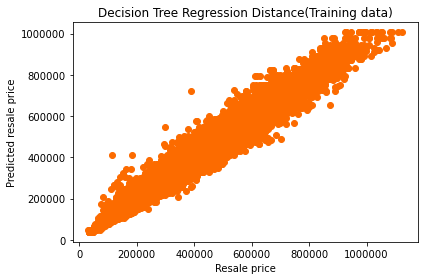

In [54]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('Decision Tree Regression Distance(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_2_core_training_data.tiff",dpi=300)
plt.show()

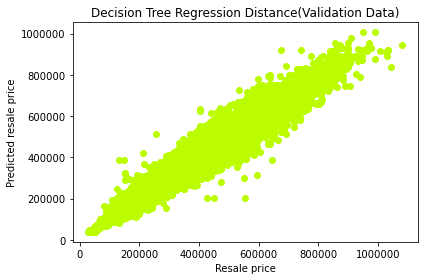

In [55]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Decision Tree Regression Distance(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./dt_2_core_validation_data.tiff",dpi=300)
plt.show()

In [56]:
dt_2_feature_importance = pd.DataFrame({'Feature':train_x.columns,'Importance':dt_2.feature_importances_}).sort_values('Importance', ascending=False)

In [57]:
dt_2_feature_importance.head()

,Feature,Importance
3,year,0.423638
0,floor_area_sqm,0.294398
245,region_central region,0.088709
36,flat_type_executive,0.044169
1,lease_commence_date,0.041471


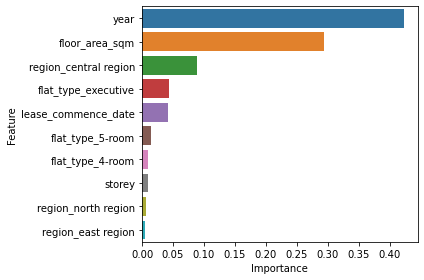

In [58]:
sns.barplot(y='Feature', x='Importance', data=dt_2_feature_importance.head(10))
plt.tight_layout()
plt.savefig("./dt_2_core_feature_importance.tiff",dpi=300)

In [122]:
scores = cross_val_score(dt_3, train_x, train_y, cv=5, scoring=custom_kfold_scorer)
print("5 fold Cross validation scores(RMSE)",scores)

5 fold Cross validation scores(RMSE) [23796.00631699 23362.31911505 23517.73451212 23610.09484359
 23380.13437972]


In [125]:
scores = cross_val_score(dt_3, train_x, train_y, cv=5, scoring='r2')
print("5 fold Cross validation scores(r2_score)",scores)

5 fold Cross validation scores(r2_score) [0.96634098 0.96781478 0.96699145 0.96705558 0.96743054]


----------------------------

## Random Forest

#### Run model using default parameters

In [40]:
rf_1 = RandomForestRegressor()

In [41]:
%%time
rf_1.fit(train_x,train_y)

Wall time: 10min 39s


RandomForestRegressor()

In [42]:
train_prediction = rf_1.predict(train_x)
val_prediction = rf_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 8064.088536574396
Validation error(RMSE) : 19565.097222302727
R2 score for training data : 0.9961479459782718
R2 score for validation data : 0.9772062250083866


#### Modify max_depth and n_estimators and try next model

In [43]:
rf_2 = RandomForestRegressor(n_estimators=50,max_depth=10,n_jobs=-1,verbose=1)

In [44]:
%%time
rf_2.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min


Wall time: 1min 50s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, verbose=1)

In [45]:
train_prediction = rf_2.predict(train_x)
val_prediction = rf_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training error(RMSE) : 34988.23491032007
Validation error(RMSE) : 35537.22993726206
R2 score for training data : 0.9274853321712171
R2 score for validation data : 0.9247997333026181


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


#### Modify max_depth and n_estimators and try next model

In [46]:
rf_3 = RandomForestRegressor(n_estimators=50,max_depth=50,n_jobs=-1,verbose=1)

In [47]:
%%time
rf_3.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min


Wall time: 2min 18s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, verbose=1)

In [48]:
train_prediction = rf_3.predict(train_x)
val_prediction = rf_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    2.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


Training error(RMSE) : 8185.21703878948
Validation error(RMSE) : 19660.658472540643
R2 score for training data : 0.9960313555366165
R2 score for validation data : 0.97698301925834


#### Modify max_depth, n_estimators and max_features and try next model

In [49]:
rf_4 = RandomForestRegressor(n_estimators=50,max_depth=50,max_features=50,n_jobs=-1,verbose=1)

In [59]:
%%time
rf_4.fit(train_x,train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.1s


Wall time: 53.4 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   53.1s finished


RandomForestRegressor(max_depth=50, max_features=50, n_estimators=50, n_jobs=-1,
                      verbose=1)

In [60]:
train_prediction = rf_4.predict(train_x)
val_prediction = rf_4.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished


Training error(RMSE) : 8186.321862355781
Validation error(RMSE) : 19380.272737437284
R2 score for training data : 0.996030284105566
R2 score for validation data : 0.9776348402142833


In [62]:
feature_importance_rf_4 = pd.DataFrame({'Feature':train_x.columns,'Importance':rf_4.feature_importances_}).sort_values('Importance', ascending=False)

In [63]:
feature_importance_rf_4.head(10)

,Feature,Importance
3,year,0.377269
0,floor_area_sqm,0.147773
1,lease_commence_date,0.069692
33,flat_type_3-room,0.056335
36,flat_type_executive,0.048273
245,region_central region,0.048045
35,flat_type_5-room,0.040113
4,storey,0.028786
34,flat_type_4-room,0.027571
2,month_no,0.010463


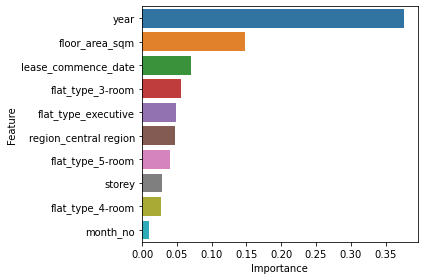

In [65]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_rf_4.head(10))
plt.tight_layout()
plt.savefig("./rf_4_core_feature_importance.tiff",dpi=300)

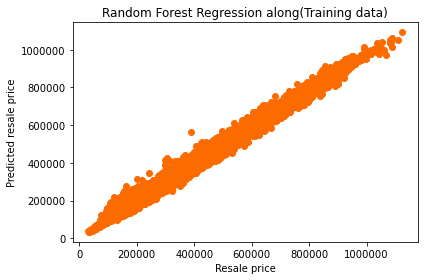

In [66]:
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
plt.title('Random Forest Regression along(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./rf_4_core_training_data.tiff",dpi=300)
plt.show()


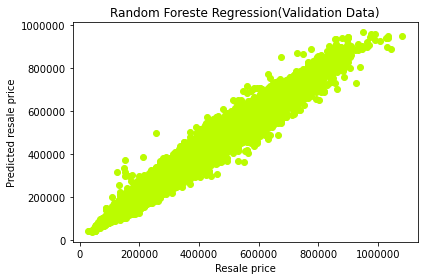

In [67]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('Random Foreste Regression(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./rf_4_core_validation_data.tiff",dpi=300)
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [68]:
#test_result = rf.predict(test_df)
#save_to_csv(test_result,"./random_forest_result.csv")

----------------------------

## XGBOOST

#### Run model using default parameters

In [83]:
xgb_model_1 = xgboost.XGBRegressor()

In [84]:
%%time
xgb_model_1.fit(train_x,train_y)

Wall time: 47.1 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [85]:
train_prediction = xgb_model_1.predict(train_x)
val_prediction = xgb_model_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 21459.51
Validation error(RMSE) : 21953.79
R2 score for training data : 0.9727214422770467
R2 score for validation data : 0.9713007033649169


#### Modify hyperparameters and try next model

In [86]:
xgb_model_2 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=50,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [87]:
%%time
xgb_model_2.fit(train_x,train_y)

Wall time: 3min 41s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=50,
             min_child_weight=1.5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [88]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 14228.215
Validation error(RMSE) : 21322.037
R2 score for training data : 0.9880082499431324
R2 score for validation data : 0.9729286701721189


In [89]:
feature_importance_xgb = pd.DataFrame({'Variable':train_x.columns,'Importance':xgb_model_2.feature_importances_}).sort_values('Importance', ascending=False)

In [90]:
feature_importance_xgb.head(10)

,Variable,Importance
36,flat_type_executive,0.136684
56,flat_model_type s1,0.095325
33,flat_type_3-room,0.079059
57,flat_model_type s2,0.071480
55,flat_model_terrace,0.042997
245,region_central region,0.040882
34,flat_type_4-room,0.028932
40,flat_model_apartment,0.026904
32,flat_type_2-room,0.026495
3,year,0.022572


In [91]:
train_prediction = xgb_model_2.predict(train_x)
val_prediction = xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 14228.215
Validation error(RMSE) : 21322.037
R2 score for training data : 0.9880082499431324
R2 score for validation data : 0.9729286701721189


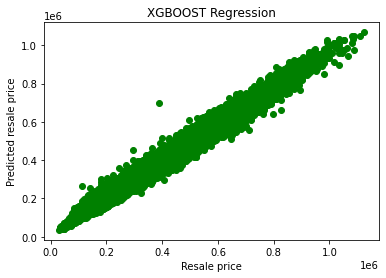

In [92]:
plt.scatter(train_y,train_prediction, color = 'green')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

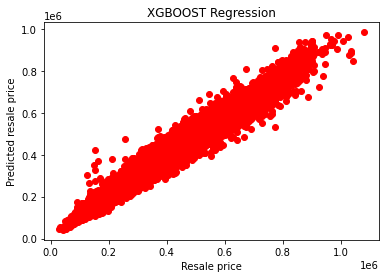

In [93]:
plt.scatter(val_y,val_prediction, color = 'red')
plt.title('XGBOOST Regression')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.show()

#### Uncomment next block to make prediction on test data and generate csv

In [19]:
#test_result = best_xgb_model.predict(test_df)
#save_to_csv(test_result,"./xgboost_result.csv")

-------------------------------------

## Prediction using Random Forest and XGBOOST together

In [82]:
xgb_model_2_prediction = xgb_model_2.predict(train_x)
rf_1_prediction = rf_1.predict(train_x)
final_pred = 0.7*rf_1_prediction + 0.3*xgb_model_2_prediction
print("Training error :",mean_squared_error(train_y, final_pred, squared=False))
print("R2 score for training data :",r2_score(train_y,final_pred))

Training error : 9164.785682885738
R2 score for training data : 0.9950115249862006


In [83]:
xgb_model_2_prediction = xgb_model_2.predict(val_x)
rf_1_prediction = rf_1.predict(val_x)
final_pred = 0.7*rf_1_prediction + 0.3*xgb_model_2_prediction
print("Validation error :",mean_squared_error(val_y, final_pred, squared=False))
print("R2 score for validation data :",r2_score(val_y,final_pred))

Validation error : 19077.86795947138
R2 score for validation data : 0.9785537934723993


In [28]:
xgb_model_2_test_prediction = best_xgb_model.predict(test_df)
rf_1_test_prediction = rf_1.predict(test_df)
final_pred_t = 0.7*rf_1_test_prediction + 0.3*xgb_model_2_test_prediction
#save_to_csv(final_pred_t, "./xgb_rf_result.csv")

----------------------

## LightGBM

#### Run model using default hyperparameters

In [69]:
gbm_1 = lgb.LGBMRegressor()

In [70]:
gbm_1 = gbm_1.fit(train_x,train_y)

In [71]:
train_prediction = gbm_1.predict(train_x)
val_prediction = gbm_1.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 24652.818685401122
Validation error(RMSE) : 24808.164675026168
R2 score for training data : 0.9639989673904366
R2 score for validation data : 0.9633527400901959


#### Modify learning_rate, max_depth and n_estimators and try next model

In [72]:
gbm_2 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=10000,n_estimators=10000)

In [73]:
gbm_2 = gbm_2.fit(train_x,train_y)

In [74]:
train_prediction = gbm_2.predict(train_x)
val_prediction = gbm_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 13351.660821922607
Validation error(RMSE) : 17131.878861287667
R2 score for training data : 0.9894402806243805
R2 score for validation data : 0.9825231875416457


In [75]:
feature_importance_gbm_2 = pd.DataFrame({'Feature':train_x.columns,'Importance':gbm_2.feature_importances_}).sort_values('Importance', ascending=False)

In [76]:
feature_importance_gbm_2.head(10)

,Feature,Importance
3,year,75444
0,floor_area_sqm,55634
2,month_no,46608
4,storey,33513
1,lease_commence_date,29259
34,flat_type_4-room,2486
45,flat_model_model a,2410
42,flat_model_improved,2401
35,flat_type_5-room,1802
245,region_central region,1508


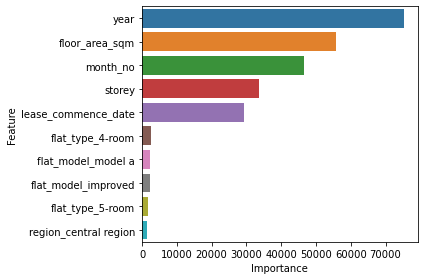

In [77]:
sns.barplot(y='Feature', x='Importance', data=feature_importance_gbm_2.head(10))
plt.tight_layout()
plt.savefig("./gbm_2_core_feature_importance.tiff",dpi=300)

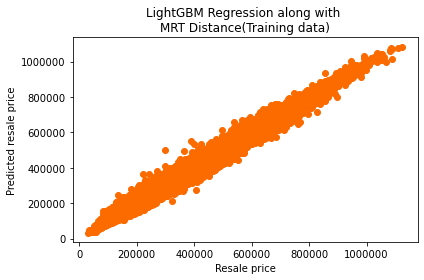

In [78]:
#plt.figure(figsize=(10,8))
plt.scatter(x=train_y,y=train_prediction, color = '#FC6B00')
#plt.scatter(val_prediction, val_y, color = 'green')
plt.title('LightGBM Regression along with \nMRT Distance(Training data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./gbm_2_core_training_data.tiff",dpi=300)
plt.show()

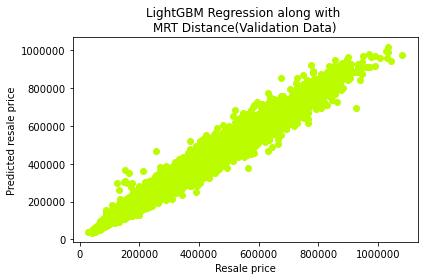

In [79]:
plt.scatter(x=val_y,y=val_prediction, color = '#BBFC00')
plt.title('LightGBM Regression along with \nMRT Distance(Validation Data)')
plt.xlabel('Resale price')
plt.ylabel('Predicted resale price')
plt.ticklabel_format(useOffset=False,style='plain')
plt.tight_layout()
plt.savefig("./gbm_2_core_validation_data.tiff",dpi=300)
plt.show()

#### Change max_depth and n_estimators and try next model

In [80]:
%%time
gbm_3 = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.1,
                        max_depth=5000,n_estimators=5000)

Wall time: 0 ns


In [81]:
gbm_3.fit(
    train_x, train_y, 
    eval_set= [(train_x, train_y), (val_x, val_y)], 
    eval_metric='rmse', verbose=1000)

[1000]	training's rmse: 17666.1	training's l2: 3.1209e+08	valid_1's rmse: 18396	valid_1's l2: 3.38414e+08
[2000]	training's rmse: 16381.1	training's l2: 2.68341e+08	valid_1's rmse: 17630.8	valid_1's l2: 3.10844e+08
[3000]	training's rmse: 15626.5	training's l2: 2.44187e+08	valid_1's rmse: 17346.2	valid_1's l2: 3.00889e+08
[4000]	training's rmse: 15074.4	training's l2: 2.27239e+08	valid_1's rmse: 17206.2	valid_1's l2: 2.96054e+08
[5000]	training's rmse: 14663.7	training's l2: 2.15025e+08	valid_1's rmse: 17139.9	valid_1's l2: 2.93777e+08


LGBMRegressor(max_depth=5000, n_estimators=5000)

In [82]:
train_prediction = gbm_3.predict(train_x)
val_prediction = gbm_3.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 14663.73696073523
Validation error(RMSE) : 17139.934995512423
R2 score for training data : 0.9872628835987185
R2 score for validation data : 0.9825067470038463


#### Uncomment next block to make prediction on test data and generate csv

In [ ]:
#gbm_test_result = gbm.predict(test_df)
#save_to_csv(gbm_test_result,"./lgbm_result.csv")

## Prediction using Random Forest, XGBOOST and LightGBM together

In [97]:
print("Training error :",mean_squared_error(train_y, , squared=False))
print("Validation error :",mean_squared_error(val_y, 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x), squared=False))

Training error : 11809.782908391793
Validation error : 13263.875122234342


In [116]:
train_prediction = 0.4*gbm_2.predict(train_x) + 0.4*rf_1.predict(train_x) +0.2*xgb_model_2.predict(train_x)
val_prediction = 0.4*gbm_2.predict(val_x)+ 0.4*rf_1.predict(val_x) +0.2*xgb_model_2.predict(val_x)
print("Training error(RMSE) :",mean_squared_error(train_y,train_prediction , squared=False))
print("Validation error(RMSE) :",mean_squared_error(val_y,val_prediction , squared=False))
print("R2 score for training data :",r2_score(train_y,train_prediction))
print("R2 score for validation data :",r2_score(val_y,val_prediction))

Training error(RMSE) : 10510.399167378899
Validation error(RMSE) : 17774.406924960822
R2 score for training data : 0.9934391275532936
R2 score for validation data : 0.9813842283136099


#### Uncomment next block to make prediction on test data and generate csv

In [117]:
#test_result = 0.4*gbm_2.predict(test_df) + 0.4*rf_1.predict(test_df) +0.2*xgb_model_2.predict(test_df)
#save_to_csv(test_result,"./lgbm_xgboost_rf_result.csv")